In [78]:
import numpy as np
from scipy.optimize import minimize

# Define the objective function
def objective(params, s1, No, sigma2, X, Y):
    d, n = X.shape

    # Extract W1 and W2 from the flattened parameter array
    W1 = params[:d * d].reshape((d, d))
    W2 = params[d * d:].reshape((d, d))

    # Calculate terms of the objective
    term1 = s1**2 * np.trace(1. / d * X @ X.T) * np.linalg.norm(W2, 'fro')**2
    term2 = No * sigma2**2 * np.trace(W1.T @ W1 @ (1. / d * X @ X.T))

    return term1 + term2

# Define the constraint function
def constraint(params, X, Y):
    d, n = X.shape

    # Extract W1 and W2 from the flattened parameter array
    W1 = params[:d * d].reshape((d, d))
    W2 = params[d * d:].reshape((d, d))

    # Constraint: W2 W1 X X^T - Y X^T = 0
    return (W2 @ W1 @ X @ X.T - Y @ X.T).flatten()

# Define the optimization function
def optimize_weights(s1, No, sigma2, X, Y):
    d, n = X.shape

    # Initial guess for W1 and W2 (flattened)
    W1_init = np.random.normal(0., 0.1, (d, d))
    W2_init = np.random.normal(0., 0.1, (d, d))
    initial_params = np.hstack((W1_init.flatten(), W2_init.flatten()))

    # Constraints definition
    cons = {'type': 'eq', 'fun': constraint, 'args': (X, Y)}

    # Optimization
    result = minimize(
        fun=objective,
        x0=initial_params,
        args=(s1, No, sigma2, X, Y),
        constraints=cons,
        method='SLSQP',
        options={'disp': True}
    )

    # Extract optimized W1 and W2
    optimized_params = result.x
    W1_opt = optimized_params[:d * d].reshape((d, d))
    W2_opt = optimized_params[d * d:].reshape((d, d))

    return W1_opt, W2_opt


# Problem dimensions
d = 3  # Dimensionality of the problem
n = 5  # Number of samples

# Example input values
s1 = 1.0
No = 1.0
sigma2 = 1.0
X = np.random.rand(d, n)
Y = np.random.rand(d, n)

# Optimize W1 and W2
W1_opt, W2_opt = optimize_weights(s1, No, sigma2, X, Y)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.099761052844422
            Iterations: 14
            Function evaluations: 275
            Gradient evaluations: 14


In [2]:
W2_opt @ W1_opt - Y @ X.T @ np.linalg.pinv(X @ X.T)

array([[-7.99653121e-10, -3.98724942e-11,  3.27387895e-10],
       [-9.48923162e-10, -2.48769005e-10,  7.28753946e-10],
       [-2.16323404e-10, -5.32382360e-10,  4.57179072e-10]])

In [3]:
import dissociation as ds

In [42]:
r1, s1, _ = ds.compact_svd(W2_opt.T @ W2_opt)
_, s2, r2 = ds.compact_svd(W1_opt @ X @ X.T @ W1_opt.T)

In [43]:
r1.T @ r2

Array([[ 1.0000001e+00, -4.8044972e-06,  1.3856572e-06],
       [ 4.7998519e-06,  9.9999982e-01,  1.1747094e-05],
       [-1.5065840e-06, -1.1764883e-05,  1.0000000e+00]], dtype=float32)

In [44]:
s1 / s2

Array([[0.18298641,        nan,        nan],
       [       nan, 0.18298359,        nan],
       [       nan,        nan, 0.1829914 ]], dtype=float32)

In [45]:
u, s1, r1 = ds.compact_svd(W2_opt)
r2, s2, v = ds.compact_svd(W1_opt)

In [46]:
r1.T @ r2

Array([[ 0.20600282,  0.583739  ,  0.7853737 ],
       [-0.924196  , -0.14770581,  0.35220006],
       [-0.32159716,  0.7983935 , -0.5090614 ]], dtype=float32)

In [47]:
s1

Array([[0.9249255 , 0.        , 0.        ],
       [0.        , 0.34936684, 0.        ],
       [0.        , 0.        , 0.20752959]], dtype=float32)

In [48]:
s1 / s2

Array([[0.30952877,        nan,        nan],
       [       nan, 0.3410007 ,        nan],
       [       nan,        nan, 0.22947985]], dtype=float32)

In [49]:
import matplotlib.pyplot as plt

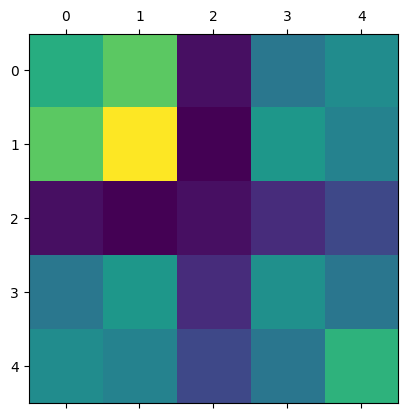

In [50]:
fig, ax = plt.subplots()
ax.matshow(X.T @ W1_opt.T @ W1_opt @ X)

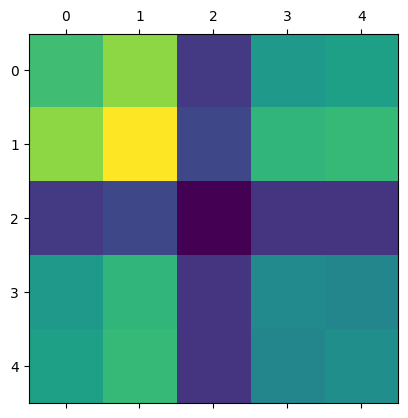

In [52]:
fig, ax = plt.subplots()
ax.matshow(X.T @ v @ s @ v.T @ X)

In [53]:
print(np.linalg.norm(W2_opt), np.linalg.norm(W1_opt))

1.0102538448518585 3.2858320195662656


In [70]:
import jax
sig_xx = 1. / n * X @ X.T
sig_yx = 1. / n * Y @ X.T

u, s, v = ds.compact_svd(sig_yx @ np.linalg.pinv(sig_xx))
r = jax.random.orthogonal(jax.random.key(1), d)[:, :s.shape[0]]
w1 = r @ np.sqrt(s) @ v.T
w2 = u @ np.sqrt(s) @ r.T

In [72]:
print(np.linalg.norm(w2), np.linalg.norm(w1))

1.4700991 1.4700993


In [65]:
u2, s2, v2 = ds.compact_svd(W2_opt)
u1, s1, v1 = ds.compact_svd(W1_opt)

In [64]:
ux, sx, vx = ds.compact_svd(X)
ux, sx, vx = ds.compact_svd(Y)

In [63]:
ut @ u

Array([[-0.41911715,  0.78354156, -0.45869765],
       [ 0.5951196 ,  0.6186277 ,  0.5129645 ],
       [ 0.68569195, -0.05798788, -0.7255783 ]], dtype=float32)

In [74]:
x = np.asarray([[1.5]])
y = np.asarray([[2.]])

u, s, v = ds.compact_svd(y @ x @ np.linalg.pinv(x @ x.T))

In [75]:
u

Array([[1.]], dtype=float32)

In [76]:
v

Array([[1.]], dtype=float32)

In [77]:
s

Array([[1.3333334]], dtype=float32)

In [80]:
2. / 1.5

1.3333333333333333

In [85]:
in_dim = 3
out_dim = 4
n = 2

x = np.random.normal(0., 1., (in_dim, n))
y = np.random.normal(0., 1., (out_dim, n))

a, b, c = ds.compact_svd(y)
d, e, f = ds.compact_svd(x)

print(y @ x.T @ np.linalg.pinv(x @ x.T))
print(a @ b @ c.T @ f @ np.linalg.pinv(e) @ d.T)

print(y @ x.T @ np.linalg.pinv(x @ x.T) @ x)
print(a @ b @ c.T @ f @ f.T)

g, h, i = ds.compact_svd(y @ x.T @ np.linalg.pinv(x @ x.T) @ x)

[[-1.09971405  0.26479683 -1.01255996]
 [-1.45398448  0.42379349 -1.18921958]
 [-3.28484898  0.85871588 -2.88700981]
 [-2.76712042  0.84636033 -2.18242443]]
[[-1.0997144   0.26479706 -1.0125602 ]
 [-1.4539849   0.4237937  -1.1892201 ]
 [-3.2848496   0.8587163  -2.8870108 ]
 [-2.767121    0.8463607  -2.182425  ]]
[[-0.65931293  0.16900919]
 [-0.72547447  0.36352381]
 [-1.83489426  0.63363611]
 [-1.30164078  0.76753137]]
[[-0.659313    0.16900934]
 [-0.7254746   0.3635239 ]
 [-1.8348945   0.63363624]
 [-1.301641    0.7675315 ]]


In [86]:
print(g)

[[-0.25243255  0.38925907]
 [-0.3038846  -0.1887708 ]
 [-0.72655004  0.5158555 ]
 [-0.5621895  -0.739416  ]]


In [87]:
print(a)

[[-0.25243255  0.38925907]
 [-0.3038846  -0.1887708 ]
 [-0.72655004  0.5158555 ]
 [-0.5621895  -0.739416  ]]


In [88]:
print(h)

[[2.665214   0.        ]
 [0.         0.26468888]]


In [89]:
print(b)

[[2.665214   0.        ]
 [0.         0.26468888]]


In [99]:
n = 5
print(np.linalg.trace(w1.T @ w1 @ (1. / n * X @ X.T)))
print(1. / n * np.linalg.trace(X.T @ w1.T @ w1 @ X))

0.89641047
0.89641047


In [98]:
1. / n * np.linalg.norm(w1 @ X)**2

np.float32(0.8964104)

In [4]:
a, b, c = ds.compact_svd(W2_opt)
d, e, f = ds.compact_svd(Y)

In [61]:
(g @ np.linalg.pinv(e) @ d.T).T @ (g @ np.linalg.pinv(e) @ d.T)

Array([[ 1.3052964 ,  0.33361754, -1.9074214 ],
       [ 0.33361754,  1.4284407 , -1.4763883 ],
       [-1.9074214 , -1.4763883 ,  4.402954  ]], dtype=float32)

In [62]:
W1_opt

array([[ 0.8340392 ,  0.53435023, -1.45002551],
       [ 1.58144566,  0.71812155, -1.52453665],
       [ 0.30937973,  0.89819108, -0.21312691]])

In [63]:
W2_opt

array([[0.00437652, 0.44311841, 0.15494625],
       [0.33741507, 0.55434539, 0.12690421],
       [0.07186918, 0.33527601, 0.47712845]])

In [ ]:
a @ b @ c.T @ g @ g.T @ 

In [5]:
a

Array([[-0.47985643, -0.0160414 , -0.87720025],
       [-0.67113394, -0.6372607 ,  0.37878507],
       [-0.56508136,  0.7704813 ,  0.29502794]], dtype=float32)

In [6]:
d

Array([[-0.4942904 ,  0.5173428 , -0.698594  ],
       [-0.6487649 , -0.75443465, -0.09966175],
       [-0.5786028 ,  0.40396142,  0.70854366]], dtype=float32)

In [8]:
Y @ X.T @ np.linalg.pinv(X @ X.T)

array([[ 0.75235511,  0.45972281, -0.71491954],
       [ 1.1973461 ,  0.69236942, -1.36142703],
       [ 0.73777638,  0.70772475, -0.71704162]])

In [9]:
Y @ np.linalg.pinv(X)

array([[ 0.75235511,  0.45972281, -0.71491954],
       [ 1.1973461 ,  0.69236942, -1.36142703],
       [ 0.73777638,  0.70772475, -0.71704162]])

In [10]:
Y @ np.linalg.pinv(X) @ X

array([[0.46071661, 0.19696137, 0.62450519, 0.18681454, 0.4378715 ],
       [0.59431701, 0.14028135, 0.97777764, 0.18007759, 0.5982239 ],
       [0.56250508, 0.20345631, 0.63988081, 0.42163185, 0.54319216]])

In [51]:
a, b, c = ds.compact_svd(Y)
d, e, g = ds.compact_svd(X)

In [52]:
k = c.T @ g @ g.T
a @ b @ k

Array([[0.4607166 , 0.19696136, 0.62450516, 0.18681468, 0.43787152],
       [0.5943169 , 0.1402814 , 0.9777775 , 0.18007761, 0.59822375],
       [0.5625049 , 0.20345621, 0.63988066, 0.42163193, 0.54319197]],      dtype=float32)

In [55]:
u, s, v = ds.compact_svd(W2_opt @ W1_opt @ X)
a @ b @ k @ v @ np.linalg.pinv(s)

Array([[-0.47985655,  0.01604646,  0.8771984 ],
       [-0.67113465,  0.6372565 , -0.3787892 ],
       [-0.5650801 , -0.7704849 , -0.295024  ]], dtype=float32)

In [77]:
a, b, c = ds.compact_svd(W2_opt)

In [57]:
a

Array([[-0.47985643, -0.0160414 , -0.87720025],
       [-0.67113394, -0.6372607 ,  0.37878507],
       [-0.56508136,  0.7704813 ,  0.29502794]], dtype=float32)

In [39]:
W2_opt @ W1_opt @ X

array([[0.46071661, 0.19696137, 0.62450519, 0.18681454, 0.4378715 ],
       [0.59431701, 0.14028135, 0.97777764, 0.18007759, 0.5982239 ],
       [0.56250508, 0.20345631, 0.63988081, 0.42163185, 0.54319216]])

In [41]:

d, e, f = ds.compact_svd(W1_opt @ X)

In [44]:
a

Array([[-0.47985643, -0.0160414 , -0.87720025],
       [-0.67113394, -0.6372607 ,  0.37878507],
       [-0.56508136,  0.7704813 ,  0.29502794]], dtype=float32)

In [46]:
a

Array([[-0.4942904 ,  0.5173428 , -0.698594  ],
       [-0.6487649 , -0.75443465, -0.09966175],
       [-0.5786028 ,  0.40396142,  0.70854366]], dtype=float32)

In [29]:
f

Array([[-0.4841164 , -0.1789474 , -0.19090322],
       [-0.15674071, -0.24301979, -0.87085676],
       [-0.6801134 ,  0.5302999 ,  0.16559263],
       [-0.23165733, -0.78394586,  0.41967297],
       [-0.47417757, -0.11458776,  0.04022928]], dtype=float32)

In [31]:
a

Array([[-0.4942904 ,  0.5173428 , -0.698594  ],
       [-0.6487649 , -0.75443465, -0.09966175],
       [-0.5786028 ,  0.40396142,  0.70854366]], dtype=float32)

In [32]:
g

Array([[-0.54937035, -0.01964059, -0.02532949],
       [-0.5616369 ,  0.34208193,  0.6399696 ],
       [-0.3466461 ,  0.32545164, -0.7383161 ],
       [-0.28253102, -0.8743741 ,  0.00277654],
       [-0.42751464, -0.11020582, -0.21137379]], dtype=float32)

In [94]:
a, b, c = ds.compact_svd(Y)
d, e, g = ds.compact_svd(X)
u_, _, r = ds.compact_svd(W2_opt)
u, s, v = ds.compact_svd(a @ b @ c.T @ g @ g.T)

In [95]:
u_

Array([[ 0.5945222 , -0.6824779 ,  0.42516735],
       [ 0.5886828 ,  0.00925694, -0.8083112 ],
       [ 0.54771864,  0.73084754,  0.40726653]], dtype=float32)

In [96]:
u

Array([[-0.5945266 ,  0.68247056,  0.42517257],
       [-0.5886829 , -0.00925449, -0.80831105],
       [-0.5477139 , -0.7308544 ,  0.40726084]], dtype=float32)

In [85]:
W2_opt @ W1_opt @ X

array([[0.84838151, 0.78194975, 0.33606017, 0.13991972, 0.71509669],
       [0.5553114 , 0.83930523, 0.63822787, 0.21013524, 0.5236236 ],
       [0.30037231, 0.92958919, 0.81623333, 0.30426915, 0.15631   ]])

In [86]:
a @ b @ c.T @ g @ g.T

Array([[0.8483817 , 0.78194994, 0.33606   , 0.1399198 , 0.7150967 ],
       [0.55531156, 0.8393056 , 0.63822794, 0.21013537, 0.52362365],
       [0.30037242, 0.9295897 , 0.8162334 , 0.30426934, 0.15630981]],      dtype=float32)

In [87]:
u

Array([[-0.5945266 ,  0.68247056,  0.42517257],
       [-0.5886829 , -0.00925449, -0.80831105],
       [-0.5477139 , -0.7308544 ,  0.40726084]], dtype=float32)

In [91]:
a @ b @ c.T @ g @ g.T @ v @ np.linalg.pinv(s)

Array([[-0.59452677,  0.68247056,  0.42517203],
       [-0.588683  , -0.00925449, -0.8083117 ],
       [-0.54771394, -0.7308539 ,  0.4072613 ]], dtype=float32)

In [92]:
a @ b @ c.T @ g @ g.T @ v @ np.linalg.pinv(s) @ np.sqrt(s) @ r.T

Array([[-0.51757365, -0.65200216,  0.64977974],
       [ 0.14789581, -0.59634537,  0.67300427],
       [ 0.39818645, -0.012149  ,  0.93864435]], dtype=float32)

In [93]:
W2_opt

array([[ 0.25549737,  0.57269934, -0.38486611],
       [ 0.09681181,  0.1903763 , -0.59793615],
       [-0.37813187,  0.12189907, -0.58899921]])

In [89]:
a @ b @ c.T @ g @ g.T @ v @ np.linalg.pinv(s)

Array([[-0.51757365, -0.65200216,  0.64977974],
       [ 0.14789581, -0.59634537,  0.67300427],
       [ 0.39818645, -0.012149  ,  0.93864435]], dtype=float32)

array([[ 0.25549737,  0.57269934, -0.38486611],
       [ 0.09681181,  0.1903763 , -0.59793615],
       [-0.37813187,  0.12189907, -0.58899921]])